# Lab 5: Spam Detection

**Deadline**: Thursday, July 9, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Baiwu (Chris) Zhang  

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/14t7GIgTAEOm2v1RFVveSk-3zr_yFAkYk?usp=sharing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [2]:
i = 0
for line in open('SMSSpamCollection'):
    i+=1
    if i == 1:
      print(line)
    if i == 3:
      print(line)

# The label value for a spam message is spam and the label value for a non-spam
# message is ham.

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [4]:
num_ham = 0
num_spam = 0
for line in open('SMSSpamCollection'):
  x = line.split("\t")
  if x[0] == "ham":
    num_ham+=1
  if x[0] == "spam":
    num_spam+=1

print("Number of spam messages: " + str(num_spam))
print("Number of non-spam messages: " + str(num_ham))

# There are 747 spam messages and 4827 non-spam messages in the data set.


Number of spam messages: 747
Number of non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
# An advantage of using character level RNNs is that there are less characters
# in the English language than words. It uses less memory than the memory to 
# store word embeddings and uses less parameters in the model, 
# decreasing computational cost.

# Another advantage of using character level RNNs is that they do not require
# tokenization as a pre-processing step.

# A disadvantage of using character level RNNs is that they can sometimes
# generate meaningless words and typos.

# Another disadvantage of character level RNNs is that they require longer 
# training times as sequence length increases and is more prone to vanishing
# and exploding gradients.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [9]:
import torchtext
import random

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

train, valid, test = dataset.split(split_ratio = [60,20,20], stratified=False, strata_field='label', random_state = random.seed(1))

#dataset[0].sms
#dataset[0].label
# train, valid, test = ...

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [10]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

# Having a balanced training set is helpful for training the neural network
# because it learns both the high and low occurance classes well. If the
# training set is not balanced, the neural network may optimize by only learning
# to classify the high occurance class and ignore the low occurance class.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [11]:
text_field.build_vocab(train)
print(text_field.vocab.stoi) # This variable represents a dictionary of different
# characters numbered from 0 to 114 which each represent a different token.
print(text_field.vocab.itos) # This variable represents a list of all the different
# characters which each represent a different token.

defaultdict(<function _default_unk_index at 0x7fa8b65e12f0>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, 'S': 32, '5': 33, 'O': 34, 'I': 35, 'N': 36, 'C': 37, '4': 38, '7': 39, 'A': 40, 'R': 41, '3': 42, 'x': 43, '6': 44, '!': 45, ',': 46, '9': 47, 'P': 48, 'M': 49, 'U': 50, 'W': 51, 'L': 52, 'H': 53, 'D': 54, 'G': 55, 'F': 56, 'Y': 57, 'B': 58, '/': 59, '?': 60, "'": 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'j': 69, 'K': 70, '*': 71, ')': 72, 'J': 73, '+': 74, ';': 75, '(': 76, 'q': 77, '"': 78, '#': 79, 'Q': 80, '=': 81, '@': 82, 'Z': 83, '>': 84, 'ü': 85, '$': 86, '\x92': 87, 'Ü': 88, '|': 89, '<': 90, '_': 91, '‘': 92, '[': 93, ']': 94, '¡': 95, '…': 96, '%': 97, '–': 98, '’': 99, '\x93': 100, 'ú': 101, '“': 102, '\\'

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# The token <unk> represents tokens that are not in the vocabulary and the token
# <pad> is used to represent padding to create batches of equal length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [12]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [16]:
acc = 0
for batch in train_iter:
    if acc == 10:
      break
    num_pad = 0
    m_lens = batch.sms[1]
    m_lens_np = m_lens.numpy()

    m_max = np.amax(m_lens_np)

    for i in m_lens_np:
      num_pad += (m_max - i)

    print(acc)
    print("Max Length: " + str(m_max))
    print("Pad Tokens: " + str(num_pad))
    
    print(len(batch))
    print(batch.sms)
    print(batch.label)
    acc+=1

#The maximum length of the input sequence in each batch is the first entry of the
#second tensor from batch.sms. In this case, the maximum length of the input
#sequence in each batch were 150, 45, 159, 133, 152, 143, 139, 101, 158 and 143
#respectively. The number of pad tokens used in each sequence is the number of
#characters less than the maximum length of the input sequence in each batch, so
#the number of pad tokens in each batch is the number of pad tokens in each
#sequence from a batch added together. In this cases, the number of pad tokens
#used in each batch were 30, 35, 28, 20, 0, 29, 43, 39, 6 and 0 respectively.

0
Max Length: 150
Pad Tokens: 30
32
(tensor([[57,  4, 12,  ..., 23, 44, 74],
        [37,  4,  7,  ...,  3, 23, 44],
        [27, 13,  3,  ..., 30, 45,  1],
        ...,
        [51, 35, 36,  ..., 48, 49,  1],
        [54,  4, 12,  ..., 54, 66,  1],
        [51,  3, 11,  ..., 26, 42,  1]]), tensor([150, 150, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149]))
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
1
Max Length: 45
Pad Tokens: 35
32
(tensor([[53,  4, 11,  ...,  4,  7, 22],
        [35, 24,  2,  ..., 22,  3, 16],
        [57,  4, 12,  ...,  2,  9,  5],
        ...,
        [40, 18,  2,  ..., 16,  1,  1],
        [35, 24,  2,  ...,  7,  1,  1],
        [52,  4, 11,  ...,  8,  1,  1]]), tensor([45, 45, 45, 45, 45, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
        44, 44, 44, 44, 44, 44, 43, 43

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [17]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [13]:
class SpamRNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [14]:
def get_accuracy(model, data, batch_size = 32):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_iter = torchtext.data.BucketIterator(data,
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.sms), # to minimize padding
                              sort_within_batch=True, # sort within each batch
                              repeat=False) # repeat the iterator for many epochs
    correct, total = 0, 0
    for batch in data_iter:
      output = model(batch.sms[0])
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(batch.label.view_as(pred)).sum().item()
      total += batch.sms[1].shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [15]:
import matplotlib.pyplot as plt

def train_rnn_network(model, train, valid, batch_size=32, num_epochs=30, learning_rate=1e-5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loader = torchtext.data.BucketIterator(train,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  valid_loader = torchtext.data.BucketIterator(valid,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs
  train_loss = []
  val_loss = []
  train_acc = []
  val_acc = []
  epochs = []

  for epoch in range(num_epochs):
    for batch in train_loader:
      pred = model(batch.sms[0])
      loss = criterion(pred, batch.label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    train_loss.append(loss/batch_size)

    for batch in valid_loader:
      pred = model(batch.sms[0])
      loss = criterion(pred, batch.label)
      optimizer.zero_grad()
    
    val_loss.append(loss/batch_size)

    train_accuracy = get_accuracy(model, train, batch_size)
    train_acc.append(train_accuracy)

    val_accuracy = get_accuracy(model, valid, batch_size)
    val_acc.append(val_accuracy)

    epochs.append(epoch)

    print("epoch: ", epoch, end = " ")
    print("train acc: ", get_accuracy(model, train, batch_size), end = " ")
    print("val acc: ", get_accuracy(model, valid, batch_size))

  plt.title("Training Loss")
  plt.plot(epochs, train_loss, label="Training Loss")
  plt.plot(epochs, val_loss, label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc="best")
  plt.show()

  plt.title("Training Accuracy")
  plt.plot(epochs, train_acc, label="Training Accuracy")
  plt.plot(epochs, val_acc, label="Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="best")
  plt.show()

#model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
#train_rnn_network(model_1, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)

epoch:  0 train acc:  0.5231809932354397 val acc:  0.1210762331838565
epoch:  1 train acc:  0.5314304570202937 val acc:  0.14080717488789238
epoch:  2 train acc:  0.5710278831875928 val acc:  0.2179372197309417
epoch:  3 train acc:  0.7252928559643623 val acc:  0.5004484304932736
epoch:  4 train acc:  0.9364791288566243 val acc:  0.9264573991031391
epoch:  5 train acc:  0.941923774954628 val acc:  0.947085201793722
epoch:  6 train acc:  0.9473684210526315 val acc:  0.9524663677130045
epoch:  7 train acc:  0.9557828741131826 val acc:  0.9515695067264573
epoch:  8 train acc:  0.9577627454215476 val acc:  0.957847533632287
epoch:  9 train acc:  0.9488533245339053 val acc:  0.9757847533632287
epoch:  10 train acc:  0.9622174558653688 val acc:  0.9713004484304932
epoch:  11 train acc:  0.9610625309354892 val acc:  0.9730941704035875
epoch:  12 train acc:  0.9615574987625805 val acc:  0.9730941704035875
epoch:  13 train acc:  0.9655172413793104 val acc:  0.967713004484305
epoch:  14 train ac

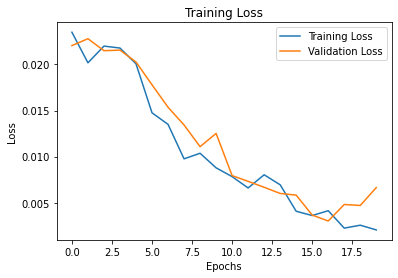

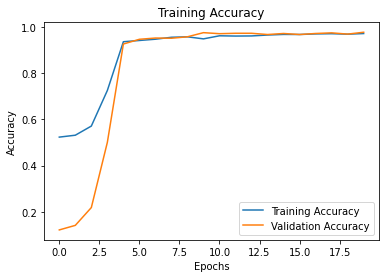

In [16]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_1, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

epoch:  0 train acc:  0.5944563603365781 val acc:  0.24394618834080717
epoch:  1 train acc:  0.9397789143705659 val acc:  0.9390134529147982
epoch:  2 train acc:  0.9290546114502557 val acc:  0.9650224215246637
epoch:  3 train acc:  0.9551229170103943 val acc:  0.95695067264574
epoch:  4 train acc:  0.9625474344167629 val acc:  0.9659192825112107
epoch:  5 train acc:  0.9661771984820987 val acc:  0.9668161434977578
epoch:  6 train acc:  0.9628774129681571 val acc:  0.947085201793722
epoch:  7 train acc:  0.9706319089259198 val acc:  0.9623318385650225
epoch:  8 train acc:  0.9767365121267118 val acc:  0.9695067264573991
epoch:  9 train acc:  0.9767365121267118 val acc:  0.968609865470852
epoch:  10 train acc:  0.9782214156079855 val acc:  0.9721973094170404
epoch:  11 train acc:  0.9589176703514272 val acc:  0.9829596412556054
epoch:  12 train acc:  0.9472034317769344 val acc:  0.9820627802690582
epoch:  13 train acc:  0.975086619369741 val acc:  0.9811659192825112
epoch:  14 train acc

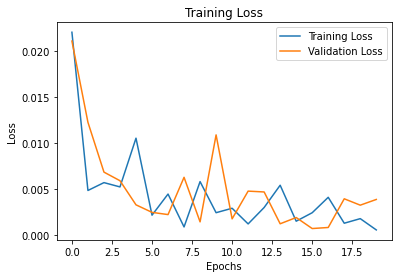

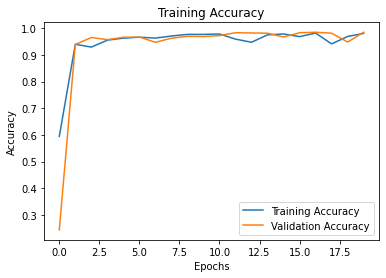

In [18]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=50, num_classes=2)
train_rnn_network(model_1, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)
#I increased the hidden size from 20 to 50 to create more weight parameters and
#intermediate states with the reasoning that it would increase the likelyhood of
#having higher accuracy when optimizing the weights eg. each weight has less effect
#on the result. The validation accuracy increased from 97.76% to 98.47% with the
#change.

epoch:  0 train acc:  0.9442336248143871 val acc:  0.9085201793721973
epoch:  1 train acc:  0.9638673486223396 val acc:  0.95695067264574
epoch:  2 train acc:  0.9688170268932519 val acc:  0.9560538116591928
epoch:  3 train acc:  0.9727767695099818 val acc:  0.9856502242152466
epoch:  4 train acc:  0.9778914370565913 val acc:  0.9802690582959641
epoch:  5 train acc:  0.9800362976406534 val acc:  0.9856502242152466
epoch:  6 train acc:  0.9856459330143541 val acc:  0.9874439461883409
epoch:  7 train acc:  0.9929054611450255 val acc:  0.9865470852017937
epoch:  8 train acc:  0.9828411153275037 val acc:  0.9641255605381166
epoch:  9 train acc:  0.9934004289721168 val acc:  0.9865470852017937
epoch:  10 train acc:  0.9902656327338722 val acc:  0.968609865470852
epoch:  11 train acc:  0.9955452895561788 val acc:  0.979372197309417
epoch:  12 train acc:  0.998020128691635 val acc:  0.9865470852017937
epoch:  13 train acc:  0.9993400428972117 val acc:  0.9856502242152466
epoch:  14 train acc:

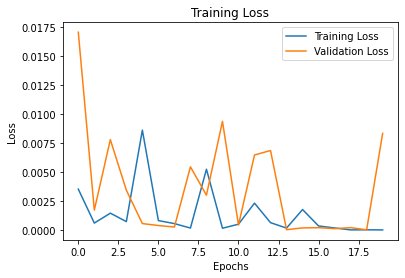

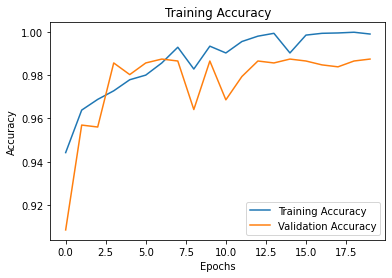

In [20]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=50, num_classes=2)
train_rnn_network(model_1, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-3)
#I increased the learning rate from 1e-4 to 1e-3 just in case that the model did
#not reach the optimal point to optimize validation accuracy with a learning rate
#of 1e-4. The validation accuracy went from 98.47% to 98.74%.

epoch:  0 train acc:  0.9599076060056096 val acc:  0.97847533632287
epoch:  1 train acc:  0.9717868338557993 val acc:  0.9641255605381166
epoch:  2 train acc:  0.9782214156079855 val acc:  0.968609865470852
epoch:  3 train acc:  0.9841610295330804 val acc:  0.9874439461883409
epoch:  4 train acc:  0.9902656327338722 val acc:  0.9883408071748879
epoch:  5 train acc:  0.9882857614255074 val acc:  0.9739910313901345
epoch:  6 train acc:  0.9950503217290876 val acc:  0.9856502242152466
epoch:  7 train acc:  0.9947203431776934 val acc:  0.9928251121076234
epoch:  8 train acc:  0.9995050321729088 val acc:  0.9865470852017937
epoch:  9 train acc:  0.9815212011219271 val acc:  0.9883408071748879
epoch:  10 train acc:  0.9988450750701204 val acc:  0.9847533632286996
epoch:  11 train acc:  1.0 val acc:  0.9856502242152466
epoch:  12 train acc:  1.0 val acc:  0.989237668161435
epoch:  13 train acc:  1.0 val acc:  0.9883408071748879
epoch:  14 train acc:  0.9991750536215146 val acc:  0.98475336322

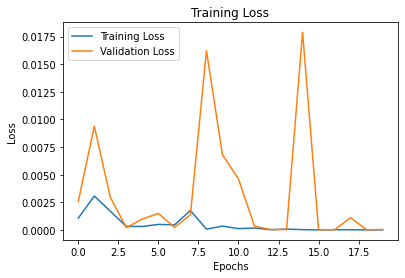

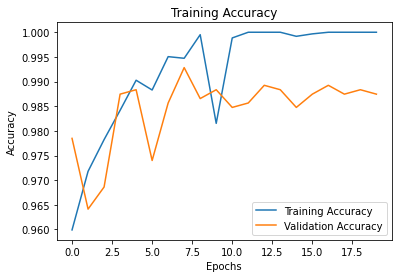

In [32]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=50, num_classes=2)
train_rnn_network(model_1, train, valid, batch_size=16, num_epochs=20, learning_rate=1e-3)

#I decreased the batch size from 32 to 16 with the reasoning that the model should
#learn how to optimize based on fewer examples at once to take into account
#individual features and messages more. The validation accuracy went from 98.74%
#to a maximum of 99.28%.

epoch:  0 train acc:  0.9610625309354892 val acc:  0.9757847533632287
epoch:  1 train acc:  0.9747566408183468 val acc:  0.9739910313901345
epoch:  2 train acc:  0.983336083154595 val acc:  0.9650224215246637
epoch:  3 train acc:  0.9914205576637518 val acc:  0.9838565022421525
epoch:  4 train acc:  0.9930704504207226 val acc:  0.9802690582959641
epoch:  5 train acc:  0.9882857614255074 val acc:  0.9874439461883409
epoch:  6 train acc:  0.9932354396964197 val acc:  0.9865470852017937
epoch:  7 train acc:  0.9981851179673321 val acc:  0.9874439461883409
epoch:  8 train acc:  0.997855139415938 val acc:  0.9865470852017937
epoch:  9 train acc:  0.9960402573832701 val acc:  0.9910313901345291
epoch:  10 train acc:  0.983336083154595 val acc:  0.9632286995515695
epoch:  11 train acc:  0.9990100643458175 val acc:  0.9883408071748879
epoch:  12 train acc:  0.9993400428972117 val acc:  0.9901345291479821
epoch:  13 train acc:  0.9998350107243029 val acc:  0.989237668161435
epoch:  14 train acc

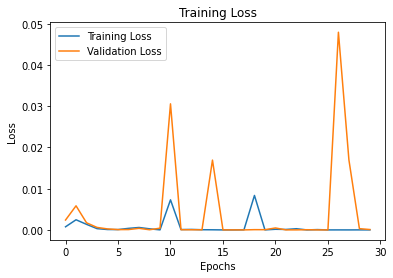

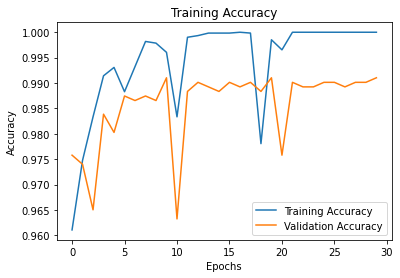

In [33]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=50, num_classes=2)
train_rnn_network(model_1, train, valid, batch_size=16, num_epochs=30, learning_rate=1e-3)
#I increased the number of epochs with the reasoning that the model should
#make more optimization steps to increase accuracy. The validation accuracy 
#increased and stayed consistently at a maximum of 99.1%. This is the best model
#I have trained so far.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [34]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

epoch:  0 train acc:  0.9683220590661606 val acc:  0.9481481481481482
epoch:  1 train acc:  0.9698069625474344 val acc:  0.9629629629629629
epoch:  2 train acc:  0.9782214156079855 val acc:  0.9629629629629629
epoch:  3 train acc:  0.9879557828741132 val acc:  0.9555555555555556
epoch:  4 train acc:  0.9864708793928395 val acc:  0.9629629629629629
epoch:  5 train acc:  0.9815212011219271 val acc:  0.9259259259259259
epoch:  6 train acc:  0.9937304075235109 val acc:  0.9629629629629629
epoch:  7 train acc:  0.9934004289721168 val acc:  0.9481481481481482
epoch:  8 train acc:  0.9968652037617555 val acc:  0.9481481481481482
epoch:  9 train acc:  1.0 val acc:  0.9481481481481482
epoch:  10 train acc:  0.9856459330143541 val acc:  0.9703703703703703
epoch:  11 train acc:  0.9991750536215146 val acc:  0.9629629629629629
epoch:  12 train acc:  1.0 val acc:  0.9555555555555556
epoch:  13 train acc:  1.0 val acc:  0.9555555555555556
epoch:  14 train acc:  1.0 val acc:  0.9555555555555556
epoch

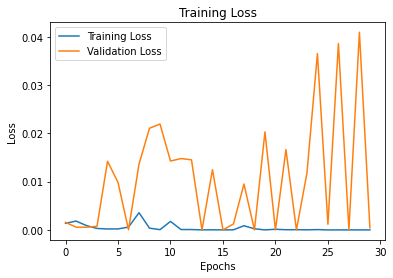

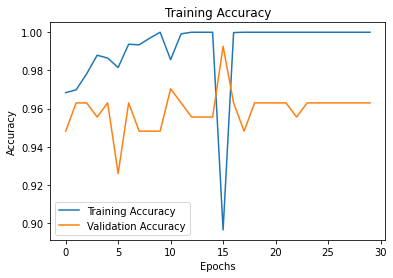

In [35]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=50, num_classes=2)
train_rnn_network(model_1, train, valid_spam, batch_size=16, num_epochs=30, learning_rate=1e-3)
#The accuracy of the spam only validation examples (negative labels) peaked and 
#stayed around 96.3%, so the false positive rate is around 3.7%. 

epoch:  0 train acc:  0.9709618874773139 val acc:  0.9806122448979592
epoch:  1 train acc:  0.9765715228510147 val acc:  0.9795918367346939
epoch:  2 train acc:  0.9821811582247154 val acc:  0.9775510204081632
epoch:  3 train acc:  0.9887807292525986 val acc:  0.9897959183673469
epoch:  4 train acc:  0.9905956112852664 val acc:  0.9897959183673469
epoch:  5 train acc:  0.9907606005609635 val acc:  0.9928571428571429
epoch:  6 train acc:  0.9808612440191388 val acc:  0.9959183673469387
epoch:  7 train acc:  0.9943903646262993 val acc:  0.9806122448979592
epoch:  8 train acc:  0.9960402573832701 val acc:  0.9806122448979592
epoch:  9 train acc:  0.9894406863553868 val acc:  0.9948979591836735
epoch:  10 train acc:  0.9871308364956278 val acc:  0.963265306122449
epoch:  11 train acc:  0.9993400428972117 val acc:  0.9887755102040816
epoch:  12 train acc:  0.9985150965187263 val acc:  0.9918367346938776
epoch:  13 train acc:  0.9990100643458175 val acc:  0.9908163265306122
epoch:  14 train 

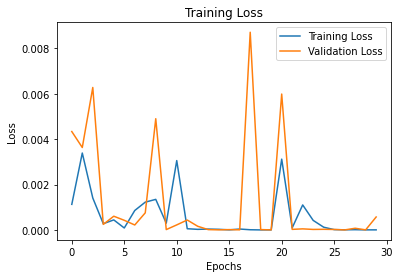

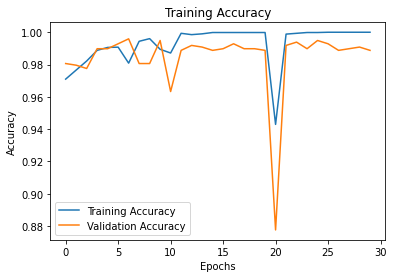

In [36]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=50, num_classes=2)
train_rnn_network(model_1, train, valid_nospam, batch_size=16, num_epochs=30, learning_rate=1e-3)
#The accuracy of the non-spam only validation examples (negative labels) peaked 
#at around 99.5%, so the false negative rate is around 0.5%. 

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
#The impact of a false positive on a phone's user is not too bad since all you
#would see is a spam message that you wouldn't normally see in your messages. If
#you are careful enough to ignore or delete the spam message, it should not 
#affect you.

#The impact of a false negative on a phone's user is very bad since there is a
#chance that you don't see a very important message if the message goes into a
#spam folder.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

epoch:  0 train acc:  0.9707968982016169 val acc:  0.9685816876122083
epoch:  1 train acc:  0.9737667051641643 val acc:  0.9605026929982047
epoch:  2 train acc:  0.9278996865203761 val acc:  0.8833034111310593
epoch:  3 train acc:  0.9863058901171424 val acc:  0.9820466786355476
epoch:  4 train acc:  0.9882857614255074 val acc:  0.9820466786355476
epoch:  5 train acc:  0.9790463619864709 val acc:  0.9829443447037702
epoch:  6 train acc:  0.9940603860749051 val acc:  0.9856373429084381
epoch:  7 train acc:  0.983336083154595 val acc:  0.9802513464991023
epoch:  8 train acc:  0.9993400428972117 val acc:  0.9820466786355476
epoch:  9 train acc:  0.9995050321729088 val acc:  0.9820466786355476
epoch:  10 train acc:  0.9976901501402409 val acc:  0.9748653500897666
epoch:  11 train acc:  0.9953803002804817 val acc:  0.9793536804308797
epoch:  12 train acc:  0.9991750536215146 val acc:  0.9802513464991023
epoch:  13 train acc:  0.9998350107243029 val acc:  0.981149012567325
epoch:  14 train a

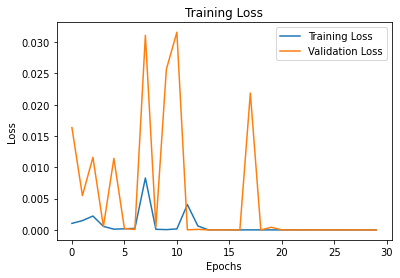

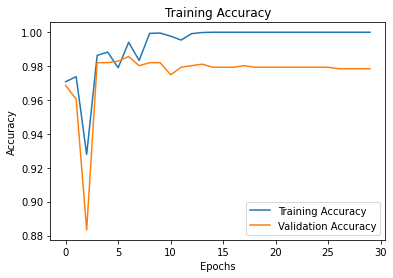

In [37]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=50, num_classes=2)
train_rnn_network(model_1, train, test, batch_size=16, num_epochs=30, learning_rate=1e-3)

#The final test accuracy of the model is around 98%.

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [38]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

epoch:  0 train acc:  0.9684870483418577 val acc:  0.9182389937106918
epoch:  1 train acc:  0.9580927239729418 val acc:  0.9433962264150944
epoch:  2 train acc:  0.98135621184623 val acc:  0.9371069182389937
epoch:  3 train acc:  0.9836660617059891 val acc:  0.9308176100628931
epoch:  4 train acc:  0.9884507507012045 val acc:  0.9371069182389937
epoch:  5 train acc:  0.9821811582247154 val acc:  0.9119496855345912
epoch:  6 train acc:  0.9955452895561788 val acc:  0.9245283018867925
epoch:  7 train acc:  0.9930704504207226 val acc:  0.9433962264150944
epoch:  8 train acc:  0.9973601715888467 val acc:  0.9245283018867925
epoch:  9 train acc:  0.9965352252103613 val acc:  0.9119496855345912
epoch:  10 train acc:  0.9892756970796899 val acc:  0.949685534591195
epoch:  11 train acc:  0.9981851179673321 val acc:  0.9433962264150944
epoch:  12 train acc:  1.0 val acc:  0.89937106918239
epoch:  13 train acc:  0.9988450750701204 val acc:  0.9308176100628931
epoch:  14 train acc:  0.99983501072

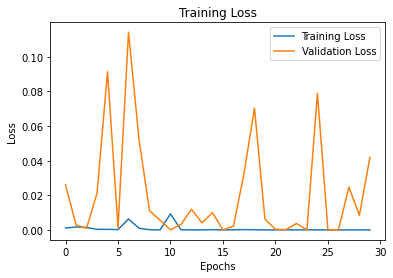

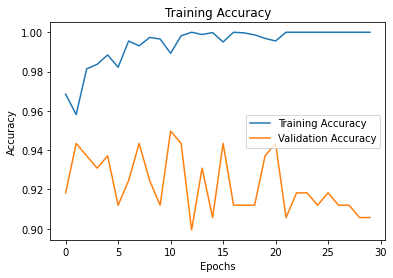

In [39]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=50, num_classes=2)
train_rnn_network(model_1, train, test_spam, batch_size=16, num_epochs=30, learning_rate=1e-3)
#The false positive rate for the test set is around 7% because the test accuracy 
#kept fluctuating between 91% and 95%.

epoch:  0 train acc:  0.9620524665896717 val acc:  0.9842931937172775
epoch:  1 train acc:  0.979211351262168 val acc:  0.9842931937172775
epoch:  2 train acc:  0.9838310509816862 val acc:  0.9790575916230366
epoch:  3 train acc:  0.9891107078039928 val acc:  0.9926701570680628
epoch:  4 train acc:  0.9940603860749051 val acc:  0.9905759162303664
epoch:  5 train acc:  0.9810262332948358 val acc:  0.9958115183246073
epoch:  6 train acc:  0.9971951823131496 val acc:  0.9926701570680628
epoch:  7 train acc:  0.9990100643458175 val acc:  0.9884816753926702
epoch:  8 train acc:  0.9990100643458175 val acc:  0.9895287958115183
epoch:  9 train acc:  0.9943903646262993 val acc:  0.9958115183246073
epoch:  10 train acc:  0.9924104933179343 val acc:  0.9895287958115183
epoch:  11 train acc:  1.0 val acc:  0.9895287958115183
epoch:  12 train acc:  1.0 val acc:  0.993717277486911
epoch:  13 train acc:  1.0 val acc:  0.987434554973822
epoch:  14 train acc:  1.0 val acc:  0.9905759162303664
epoch:  

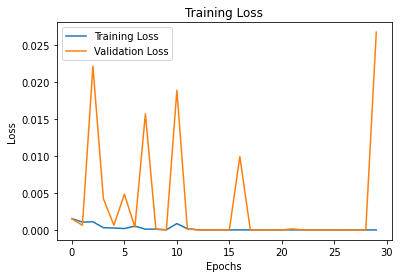

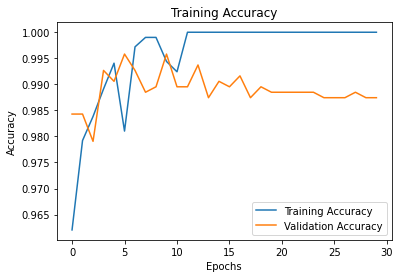

In [40]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=50, num_classes=2)
train_rnn_network(model_1, train, test_nospam, batch_size=16, num_epochs=30, learning_rate=1e-3)
#The false negative rate for the test set is around 1% because the test accuracy 
#stabilizes at around 99%.

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
for 

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
#Detecting spam is a difficult task because it requires high degrees of accuracy
#to do well. False negatives are really detrimental to the performance of spam
#detection, because they are really important to avoid. So the false negative rate
#must be extremely low for spam detection to be worthwhile.

#A simple baseline model that could be created for spam detection is to find the
#average appearance of particular words and characters in spam and non-spam
#messages. Using a large dataset of spam and non-spam messages, the average
#appearance of a particular word should be pretty accurate for spam and non-spam
#messages. When a message is inputted, the baseline model should identify the
#words and characters in the message and see if they are overall closer to the 
#average appearance of the words in non-spam messages or spam messages. The
#baseline model output would either be spam or non-spam depending on how close
#appearance rates are.